In [2]:
#Set up google colab working environment
%cd ~/../content
%rm -rf Colombian-peso-counterfeit-detection
!git clone https://github.com/zrosen3/Colombian-peso-counterfeit-detection.git
%cd /content/Colombian-peso-counterfeit-detection/Code

/content
Cloning into 'Colombian-peso-counterfeit-detection'...
remote: Enumerating objects: 42365, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 42365 (delta 123), reused 64 (delta 41), pack-reused 42174
Receiving objects: 100% (42365/42365), 886.42 MiB | 40.38 MiB/s, done.
Resolving deltas: 100% (1282/1282), done.
Updating files: 100% (103997/103997), done.
/content/Colombian-peso-counterfeit-detection/Code


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import tensorflow as tf
import common_functions as cf

# Load data

In [4]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData(path = "../Data/Augmented/", batch_size=12)


Found 24958 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.


## Create ensemble of CNNs

Create ensemble model

In [5]:
#Initialize keras session
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
#ANN
ann = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(480, 640, 3)),
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dense(
                  units = 13,
                activation = "softmax"
          )])
ann.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

ann.fit(
train_ds,
validation_data=validation_ds,
epochs=5)
  
#Model 2 = Custom CNN
cnn = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(len(class_names))])
cnn.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

cnn.fit(
train_ds,
validation_data=validation_ds,
epochs=5)
'''
#Model 3 = CNN-LTSM
cnn_ltsm = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.ConvLSTM2D(16, 3, kernel_regularizer='l2', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(len(class_names)) 
])

cnn_ltsm.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

cnn_ltsm.fit(
train_ds,
validation_data=validation_ds,
epochs=5)

'''

Epoch 1/5
2080/2080 [==============================] - 182s 84ms/step - loss: 69.8065 - accuracy: 0.3605 - val_loss: 93.8840 - val_accuracy: 0.2620
Epoch 2/5
2080/2080 [==============================] - 181s 87ms/step - loss: 21.6554 - accuracy: 0.4947 - val_loss: 6.9846 - val_accuracy: 0.5787
Epoch 3/5
2080/2080 [==============================] - 180s 86ms/step - loss: 10.4039 - accuracy: 0.5463 - val_loss: 18.4490 - val_accuracy: 0.4292
Epoch 4/5
2080/2080 [==============================] - 184s 88ms/step - loss: 16.6805 - accuracy: 0.5791 - val_loss: 10.2035 - val_accuracy: 0.5179
Epoch 5/5
2080/2080 [==============================] - 186s 89ms/step - loss: 1.3003 - accuracy: 0.7602 - val_loss: 1.0366 - val_accuracy: 0.7344
Epoch 1/5
2080/2080 [==============================] - 181s 84ms/step - loss: 2.7491 - accuracy: 0.0775 - val_loss: 2.5649 - val_accuracy: 0.0767
Epoch 2/5
2080/2080 [==============================] - 172s 82ms/step - loss: 2.5650 - accuracy: 0.0766 - val_loss: 2

"\n#Model 3 = CNN-LTSM\ncnn_ltsm = tf.keras.Sequential([\n    tf.keras.layers.Rescaling(1./255),\n    tf.keras.layers.ConvLSTM2D(16, 3, kernel_regularizer='l2', activation='relu'),\n    tf.keras.layers.MaxPooling2D(),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dropout(rate=0.4),\n    tf.keras.layers.Dense(len(class_names)) \n])\n\ncnn_ltsm.compile(\noptimizer='adam',\nloss='sparse_categorical_crossentropy',\nmetrics=['accuracy'])\n\ncnn_ltsm.fit(\ntrain_ds,\nvalidation_data=validation_ds,\nepochs=5)\n\n"

Create ensemble model

In [6]:
models = [ann, cnn]
input_layer = tf.keras.layers.Input(shape=(480, 640, 3))  
outputs = []
for i,model in enumerate(models):
    model._name = str(i)
    output = model(input_layer)
    outputs.append(output)
averaged_outputs = tf.reduce_mean(outputs, axis = 0)
output_layer = tf.keras.layers.Dense(13, activation='softmax')(averaged_outputs)  
ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

Fit ensemble model



In [7]:
ensemble_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = ensemble_model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=5)

Epoch 1/5
2080/2080 [==============================] - 250s 119ms/step - loss: 1.0980 - accuracy: 0.6832 - val_loss: 0.2474 - val_accuracy: 0.9216
Epoch 2/5
2080/2080 [==============================] - 248s 119ms/step - loss: 0.1421 - accuracy: 0.9558 - val_loss: 0.1524 - val_accuracy: 0.9530
Epoch 3/5
2080/2080 [==============================] - 245s 118ms/step - loss: 0.0816 - accuracy: 0.9771 - val_loss: 0.1595 - val_accuracy: 0.9608
Epoch 4/5
2080/2080 [==============================] - 246s 118ms/step - loss: 0.0542 - accuracy: 0.9850 - val_loss: 0.1751 - val_accuracy: 0.9597
Epoch 5/5
2080/2080 [==============================] - 238s 114ms/step - loss: 0.0408 - accuracy: 0.9889 - val_loss: 0.1767 - val_accuracy: 0.9602


## Inspect model performance

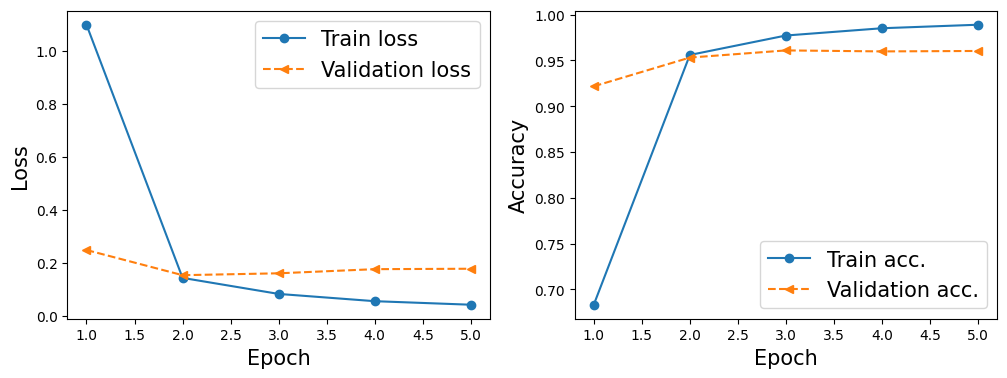

694/694 - 38s - loss: 0.2028 - accuracy: 0.9549 - 38s/epoch - 55ms/step
Test loss: 0.20284952223300934 | Test accuracy: 0.9549278616905212


(0.9888612627983093, 0.9602163434028625, 0.9549278616905212)

In [8]:
cf.EvaluateModel(ensemble_model, test_ds, history)


Macro averaged precision score: 0.9549278846153846
Macro averaged recall score: 0.9555846882919317
Macro averaged F1 score: 0.954978796862875


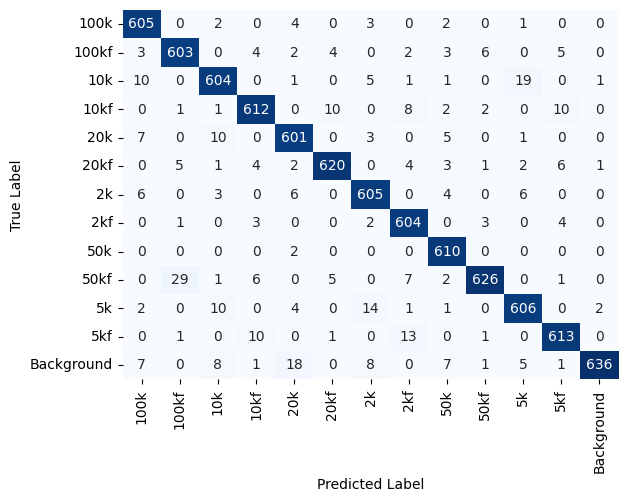

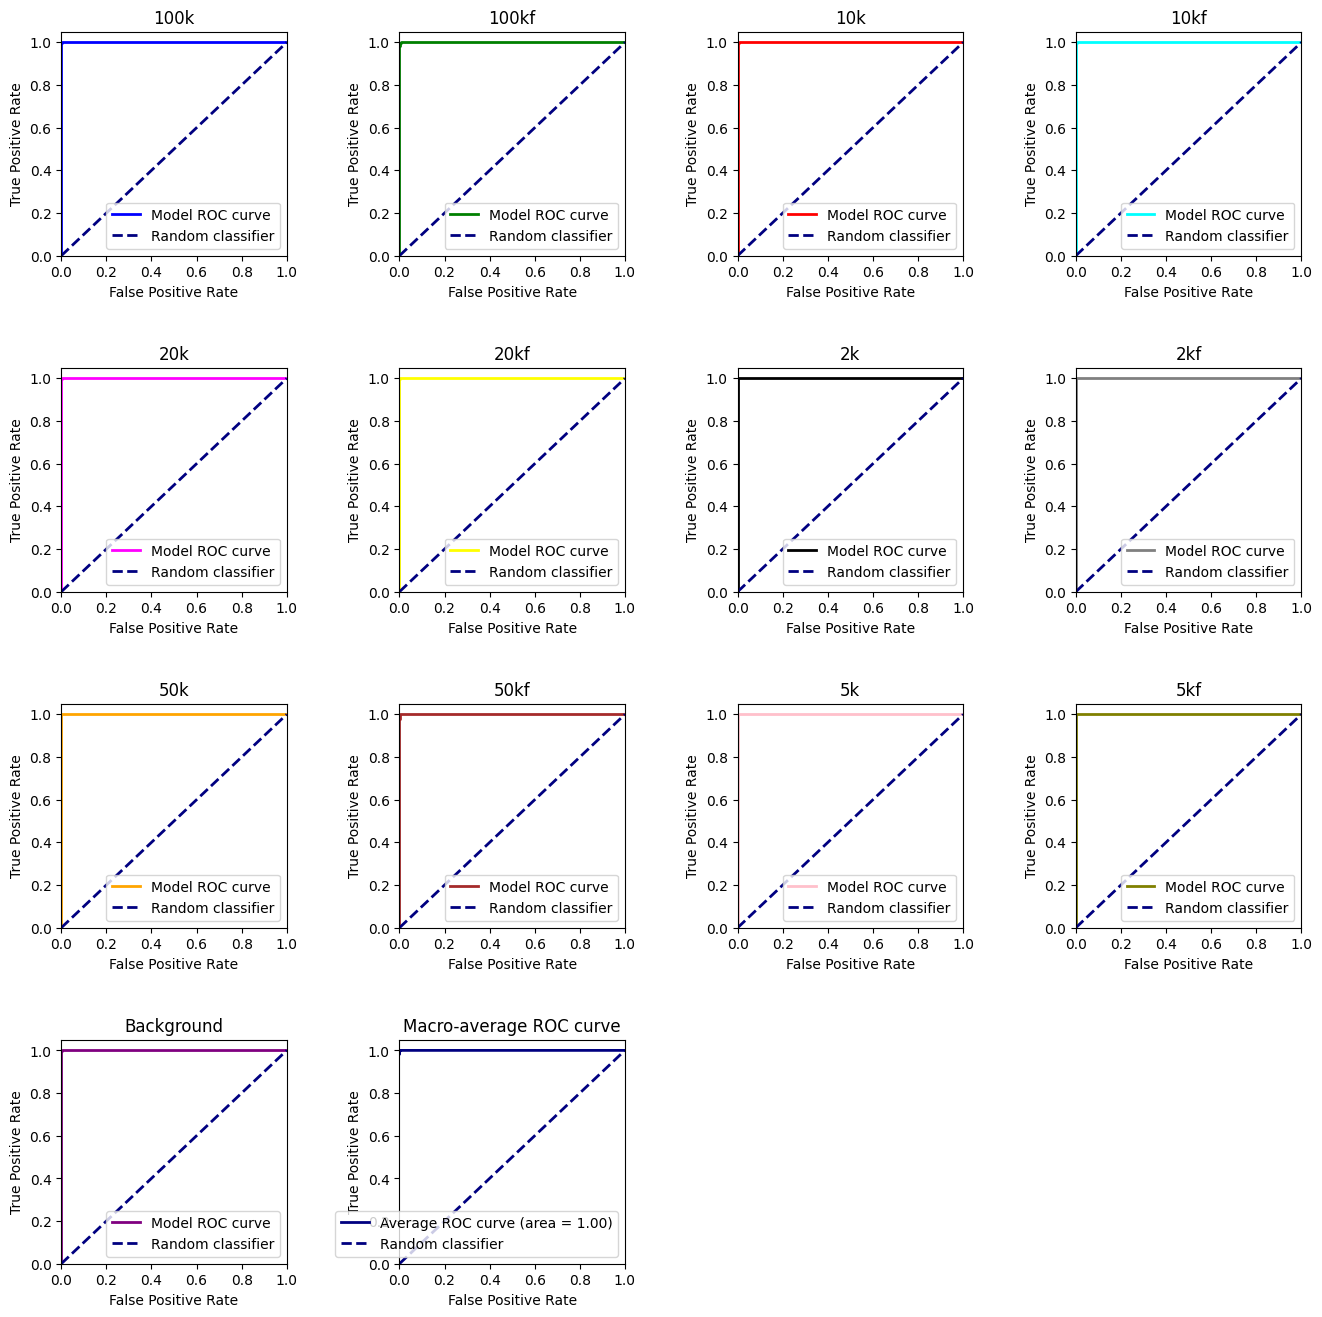

In [9]:
cf.precision_recall_metrics(ensemble_model, test_ds, class_names)